In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.neighbors import NearestCentroid
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

### Functions to describe clusters

In [2]:
def plot_parallel_coordinates_clusters(df, cluster_centers, method=None):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(cluster_centers)):
        plt.plot(cluster_centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18, rotation=90)
    plt.legend(fontsize=10)
    plt.savefig(f"images/clustering/{method}_parallel.png")
    plt.show()

In [3]:
def plot_radar_clusters(df, cluster_centers, method=None):
    # number of variable
    N = len(df.columns)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    for i in range(0, len(cluster_centers)):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = cluster_centers[i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        ax = plt.subplot(polar=True)
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], df.columns, color='grey', size=8) 
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)
    plt.savefig(f"images/clustering/{method}_radar.png")
    plt.show()

In [4]:
def plot_date_feature_clusters(df, labels, num_cluster):
    for i in range(num_cluster):
        i_samples = labels==i
        print(i)
        print(np.sum(i_samples))
        df[i_samples].name.groupby(pd.to_datetime(df.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
        plt.show()

In [5]:
def categorical_hist_clusters(df, labels, feature_name, method=None):
    bot_xt_pct = pd.crosstab(labels, df[feature_name])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                       title=f'{feature_name} per cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature_name)
    plt.savefig(f"images/clustering/{method}_{feature_name}_hist.png")
    plt.show()

In [6]:
def plot_numerical_features_clusters(df, labels, num_cluster):
    """
    print and plot distribution of numerical features conditioned by the cluster
    """
    
    for i in range(num_cluster):
        i_samples = labels==i
        df[i_samples].boxplot()
        plt.xticks(rotation=90)
        df[i_samples].hist(figsize=(10,10))
        plt.xticks(rotation=90)
        plt.show()

In [7]:
def scatter_features_clusters(df, labels):
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            feature_1 = df.columns[i]
            feature_2 = df.columns[j]
            
            print(f"{feature_1} - {feature_2}")
            plt.scatter(df[feature_1], df[feature_2], c=labels, s=20)
            plt.tick_params(axis='both', which='major', labelsize=22)
            plt.show()

### Preparation of the dataset

In [8]:
df = pd.read_csv("dataset/user_profiles.csv", index_col=0)

In [9]:
df.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,reply_count_entropy,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.0,0.037879,0.190903,1.609438,0.037879,0.190903,1.609438
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.0,0.049587,0.217090,1.791759,0.024793,0.155495,1.098612
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,19.250000,5.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.0,0.165387,0.530838,5.105129,0.826239,13.034008,2.170410
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.0,0.056365,0.243387,5.248623,0.016772,0.142619,3.965939


In [10]:
# remove categorical features
cat_features = ["name", "lang", "bot", "created_at"]
df_cat = df[cat_features]
df_num = df.loc[:, ~df.columns.isin(cat_features)]

In [11]:
df_cat.head()

,name,lang,bot,created_at
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56
466124818,Carletto Focia,it,1,2017-01-18 02:49:18
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21


In [12]:
df_num.head()

,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,reply_count_entropy,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
2353593986,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.0,0.037879,0.190903,1.609438,0.037879,0.190903,1.609438
2358850842,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.0,0.049587,0.217090,1.791759,0.024793,0.155495,1.098612
137959629,53,19.250000,5.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.0,0.165387,0.530838,5.105129,0.826239,13.034008,2.170410
2571493866,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.0,0.056365,0.243387,5.248623,0.016772,0.142619,3.965939


In [13]:
def preprocess_skewed_features(df, skewed_features):
    df_num_not_skewed = df.copy()
    df_num_not_skewed[skewed_features] = df[skewed_features].apply(lambda x: np.log(x + 1))
        
    return df_num_not_skewed

In [14]:
def reverse_log_skewed(X, df, skewed_features):
    for feature in skewed_features:
        i = list(df.columns).index(feature)
        X[:, i] = np.exp(X[:, i]) - 1
    return X

In [15]:
skewed_features = [
    "statuses_count",
    "avg_special_chars",
    "urls_ratio",
    "mentions_ratio",
    "hashtags_ratio",
    "reply_count_mean",
    "reply_count_std",
    "reply_count_entropy",
    "favorite_count_mean",
    "favorite_count_std",
    "retweet_count_mean",
    "retweet_count_std"]


df_num_not_skewed = preprocess_skewed_features(df_num, skewed_features)

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(df_num_not_skewed.values)

In [17]:
X[:5]

array([[-0.44289899, -0.35784931, -0.20148997, -0.5281303 , -0.12349501,
        -0.18233688, -0.16474895, -0.24784012, -0.28270695, -0.42595564,
        -0.44343513, -0.45495561, -0.66409772, -0.74317231, -0.30601295],
       [-0.58322656,  0.05815912,  0.04150834, -0.5281303 ,  0.08448373,
        -0.67210356, -0.16474895, -0.24784012, -0.28270695, -0.38604619,
        -0.38601636, -0.37748204, -0.67554207, -0.76132313, -0.55341544],
       [-0.59087917, -3.01683541, -3.42321754, -0.5281303 , -1.11387582,
        -0.84483898, -0.16474895, -0.24784012, -0.28270695, -0.55823009,
        -0.90465216, -1.13885118, -0.69763256, -0.84823643, -1.08549411],
       [-0.6147174 ,  1.16037331,  0.79472962, -0.36489841, -1.0881642 ,
        -0.35068874, -0.16474895, -0.24784012, -0.28270695, -0.01370058,
         0.21944516,  1.03046228, -0.15440535,  0.74023658, -0.03432346],
       [ 1.44305522,  0.25738455, -0.06526136, -0.52203627,  0.56890069,
        -0.05669003, -0.16474895, -0.24784012, 

# Hierarchical Clustering

In [18]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

###### cosine

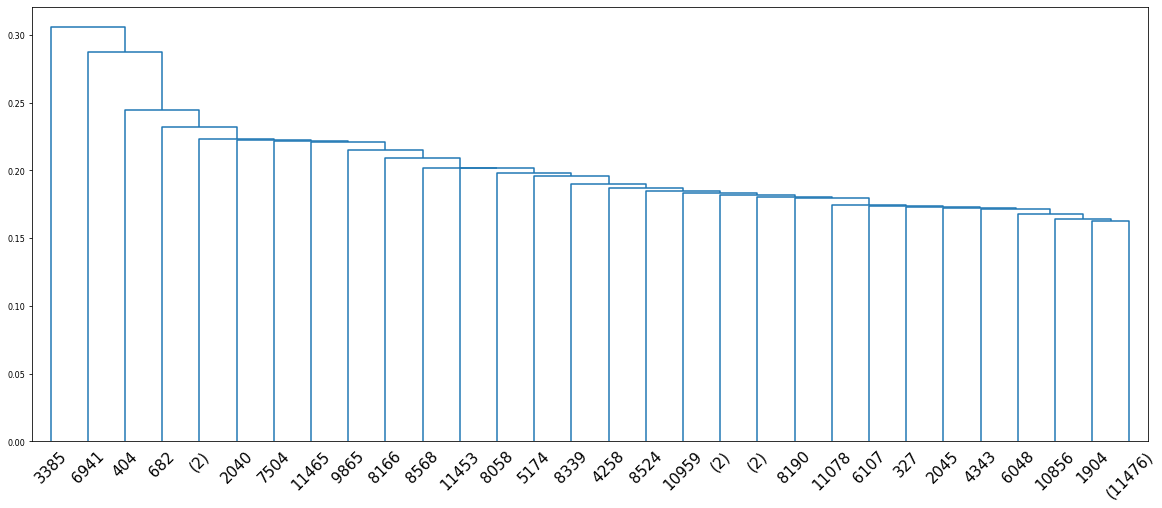

In [19]:
data_dist = pdist(X, metric='cosine')
data_link = linkage(data_dist, method='single', metric='cosine')

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=0.11, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

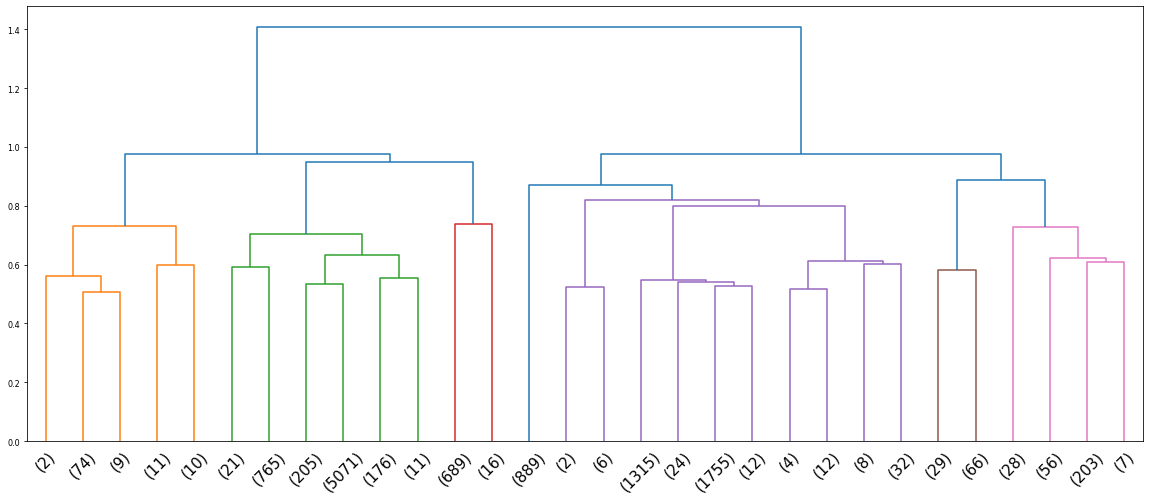

In [37]:
data_dist = pdist(X, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=0.85, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

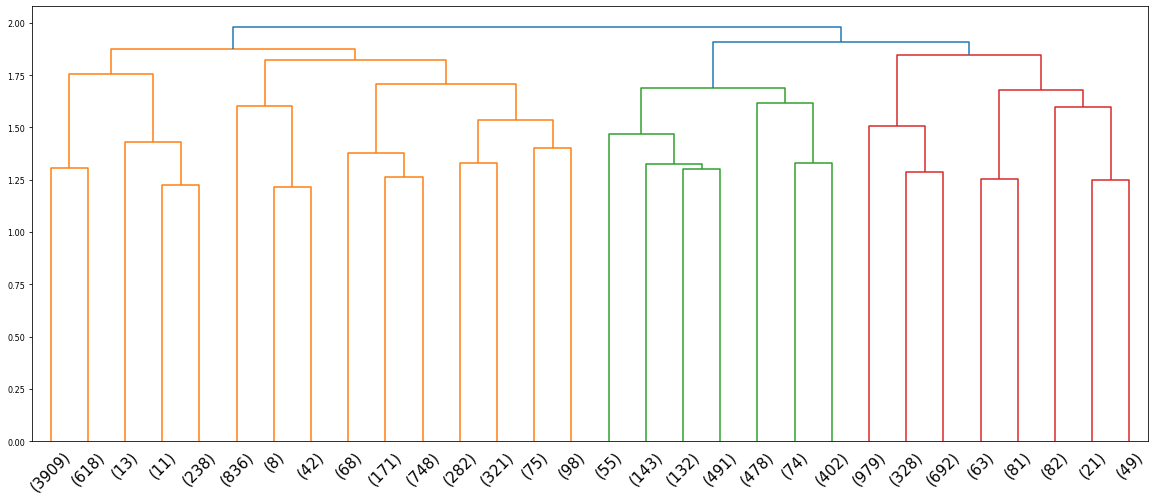

In [41]:
data_dist = pdist(X, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.9, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### euclidean

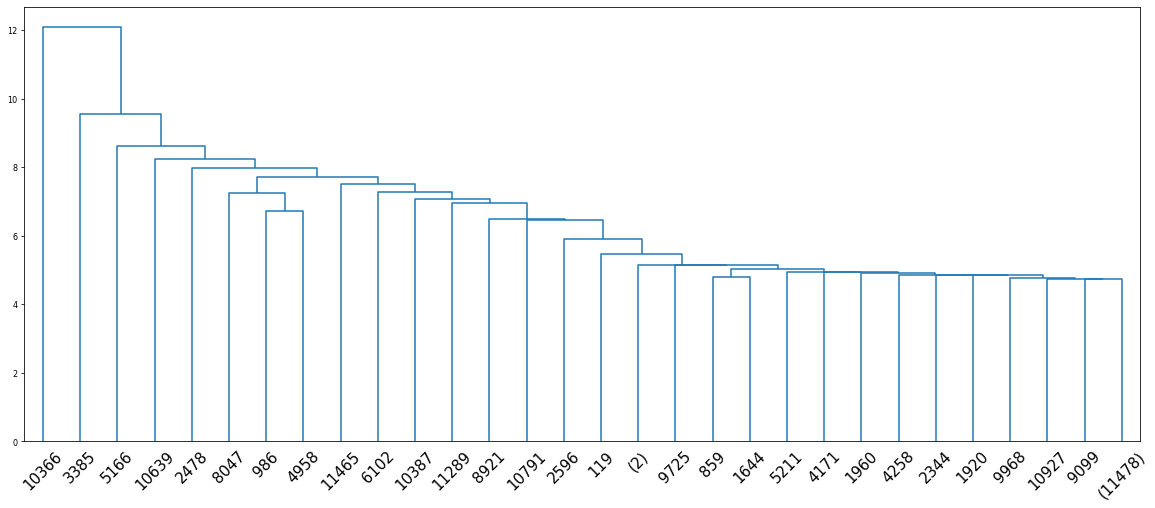

In [23]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=0.7, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

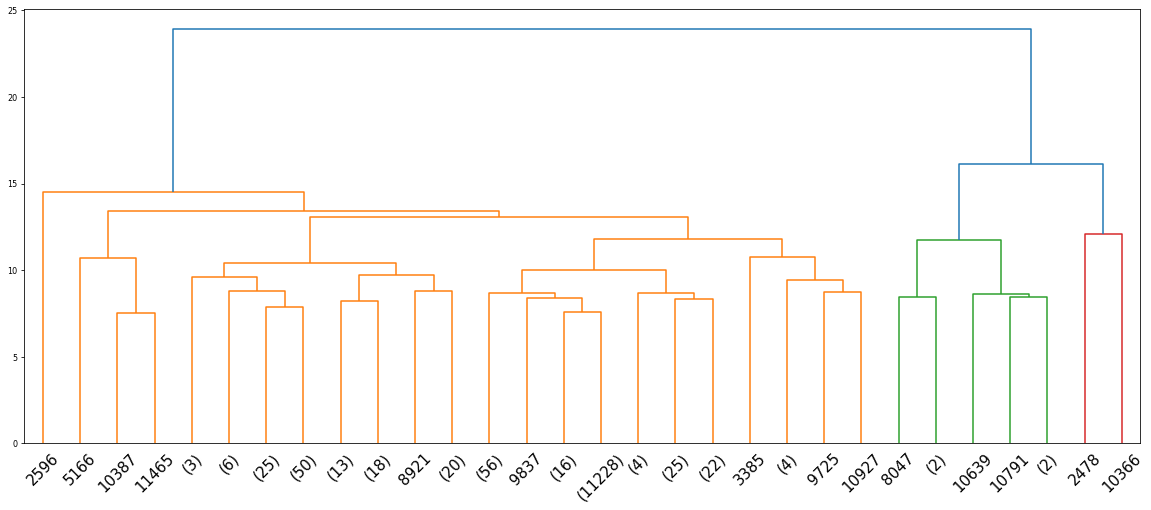

In [50]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=14.8, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

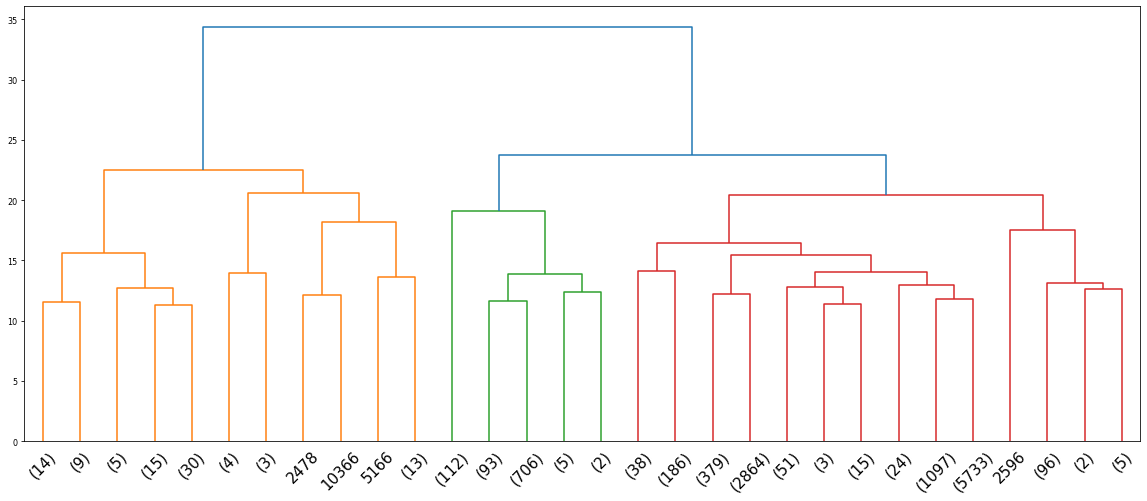

In [46]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=23, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

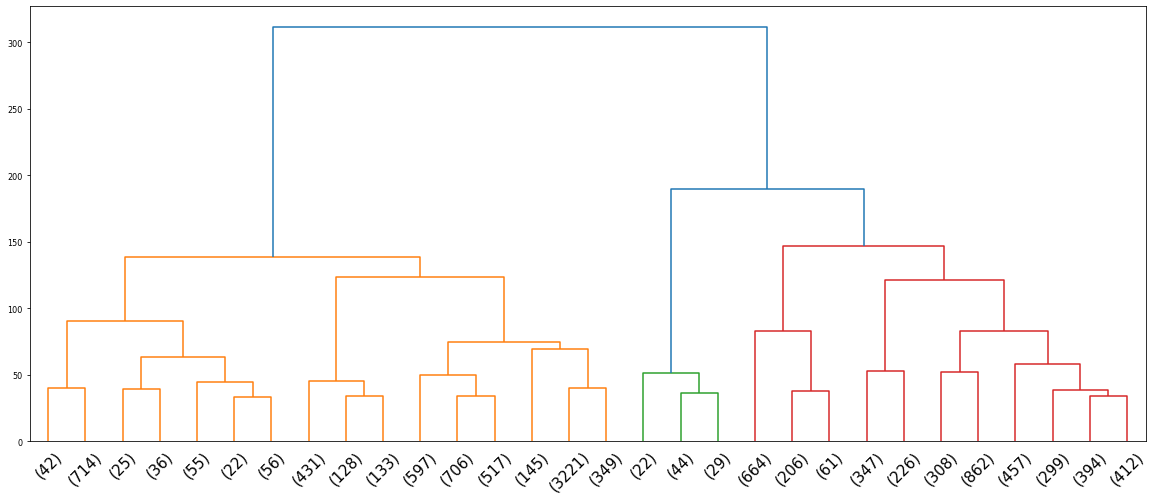

In [47]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=160, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

In [48]:
from sklearn.cluster import AgglomerativeClustering

#### AgglomerativeClustering with cosine as affinity and average as linkage

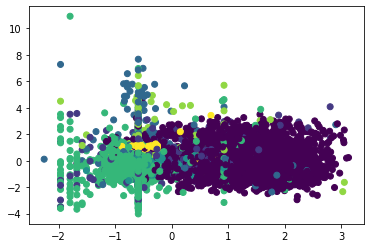

In [42]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='cosine', linkage='average')
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [43]:
print('Silhouette %s' % silhouette_score(X, res_cluster.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, res_cluster.labels_))

Silhouette 0.25995413682966895
Separation 1.3408101792002598


#### AgglomerativeClustering with cosine as affinity and complete as linkage

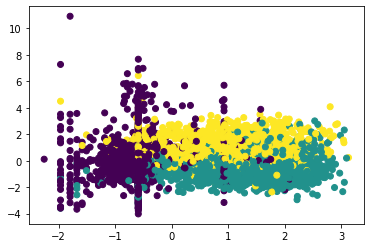

In [44]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [45]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, cluster.labels_))

Silhouette 0.33950077199998024
Separation 1.9243364011209596


#### AgglomerativeClustering with euclidean as affinity and complete as linkage

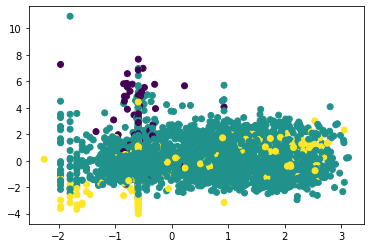

In [86]:
res_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
res_cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=res_cluster.labels_)

In [87]:
print('Silhouette %s' % silhouette_score(X, res_cluster.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, res_cluster.labels_))

Silhouette 0.30206224633826045
Separation 1.5332769334409913


#### AgglomerativeClustering with euclidean as affinity and ward as linkage

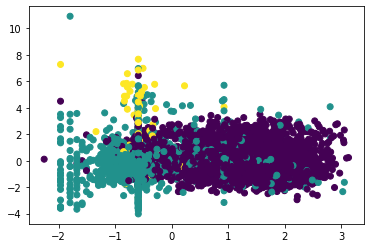

In [84]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

In [85]:
print('Silhouette %s' % silhouette_score(X, cluster.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, cluster.labels_))

Silhouette 0.3865808377256586
Separation 1.069960170308177


### Plot Cluster Results

In [ ]:
y_predict = res_cluster.fit_predict(X)
clf = NearestCentroid()
clf.fit(X, y_predict)

centers = reverse_log_skewed(scaler.inverse_transform(clf.centroids_))
plot_parallel_coordinates_clusters(df_num, centers)

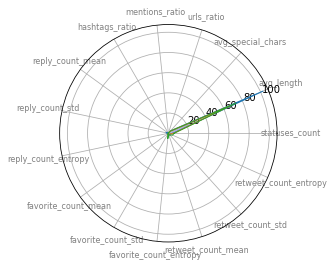

In [70]:
plot_radar_clusters(df_num, centers)

#### Distribution of CategoricalFeatures per Cluster

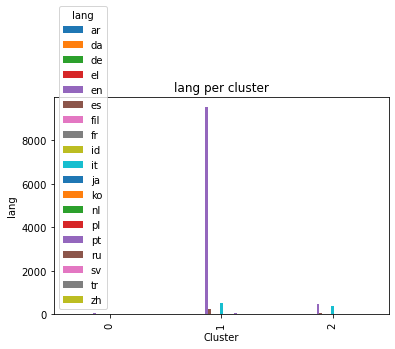

In [71]:
categorical_hist_clusters(df_cat, res_cluster.labels_, "lang")

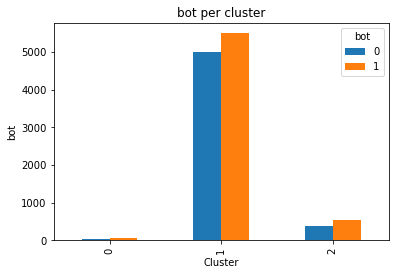

In [72]:
categorical_hist_clusters(df_cat, res_cluster.labels_, "bot")

0
96


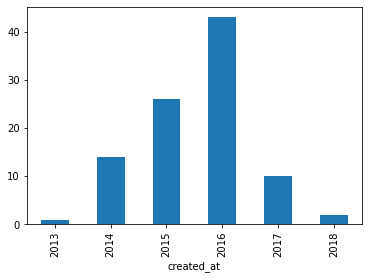

1
10494


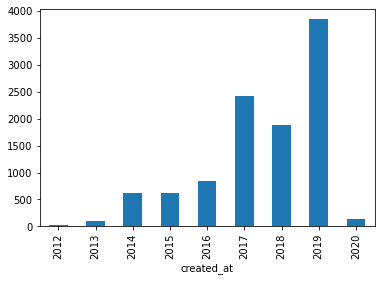

2
918


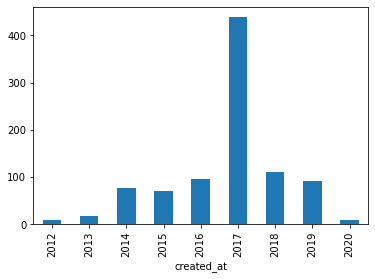

In [74]:
plot_date_feature_clusters(df_cat, res_cluster.labels_, 3)

#### Distribution of Numerical Features per Cluster

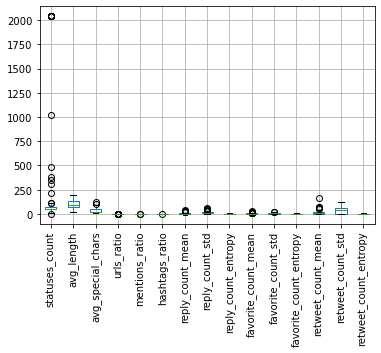

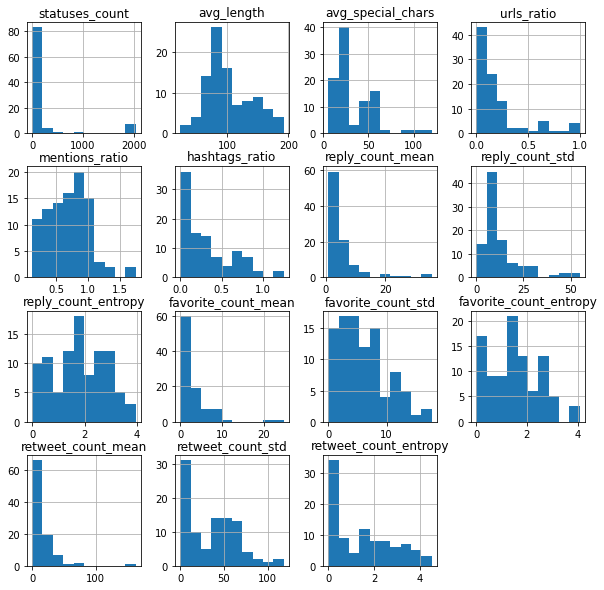

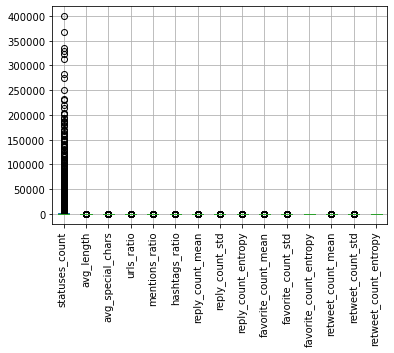

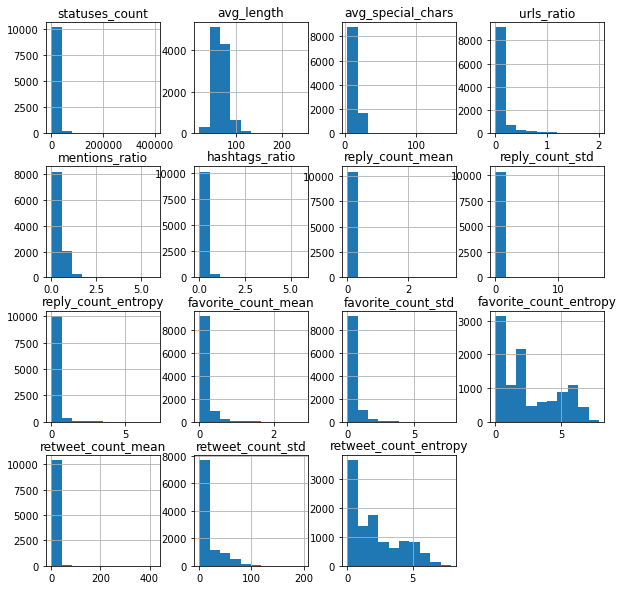

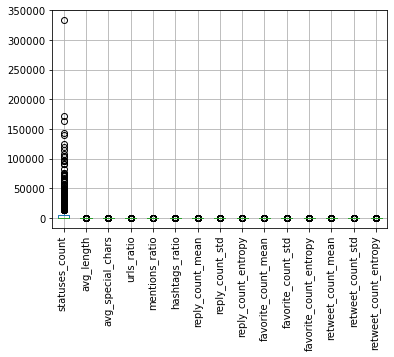

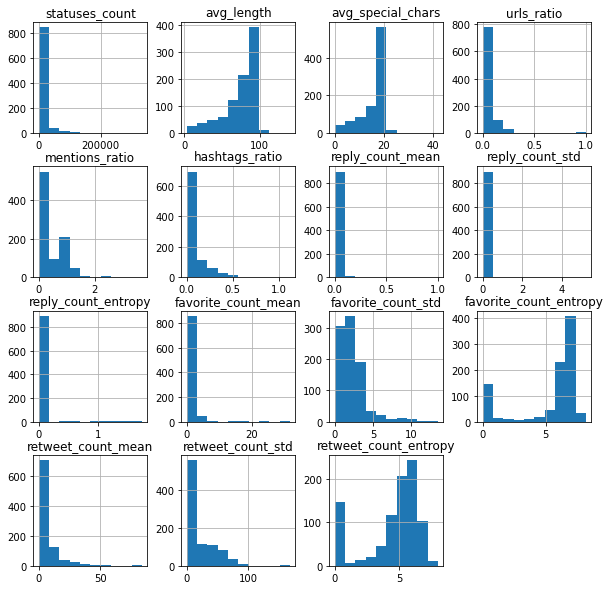

In [76]:
plot_numerical_features_clusters(df_num, res_cluster.labels_, 3)

statuses_count - avg_length


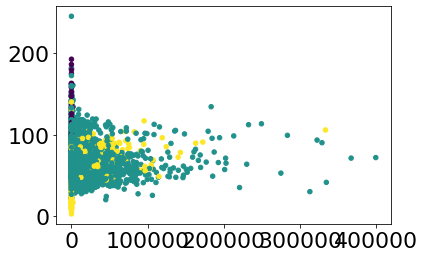

statuses_count - avg_special_chars


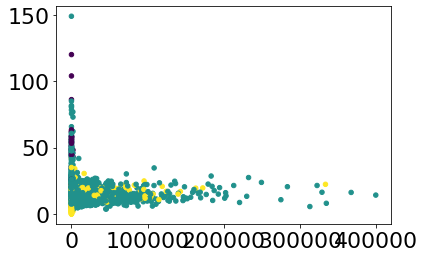

statuses_count - urls_ratio


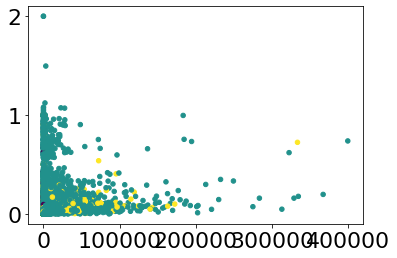

statuses_count - mentions_ratio


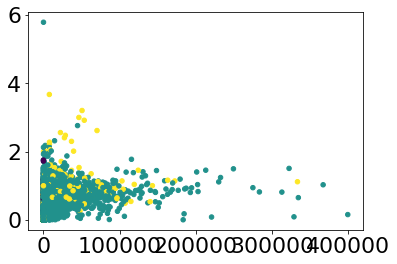

statuses_count - hashtags_ratio


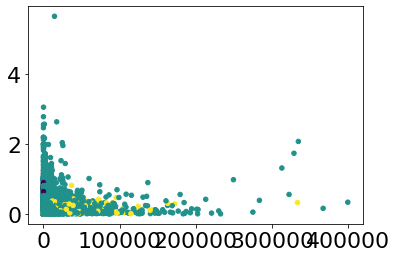

statuses_count - reply_count_mean


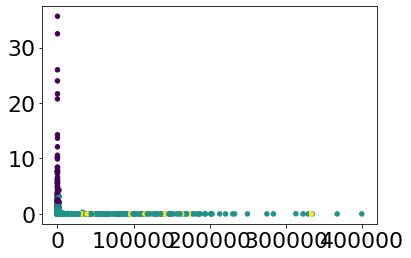

statuses_count - reply_count_std


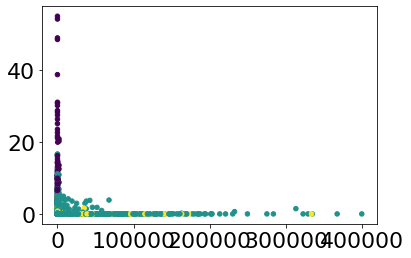

statuses_count - reply_count_entropy


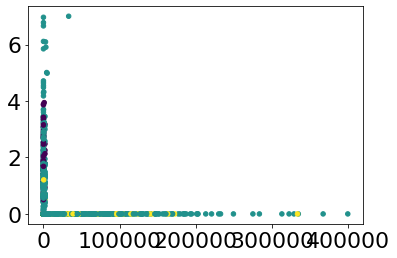

statuses_count - favorite_count_mean


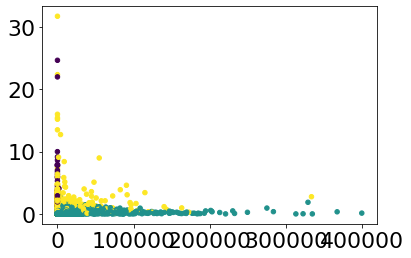

statuses_count - favorite_count_std


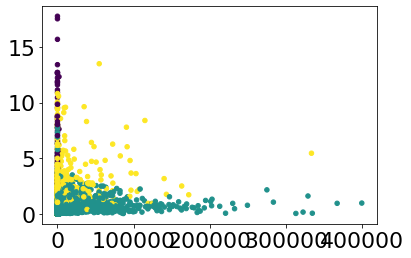

statuses_count - favorite_count_entropy


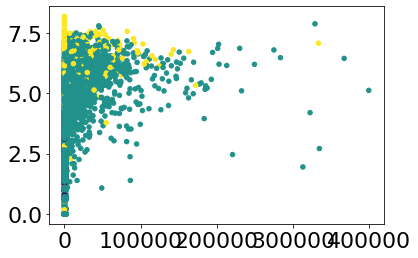

statuses_count - retweet_count_mean


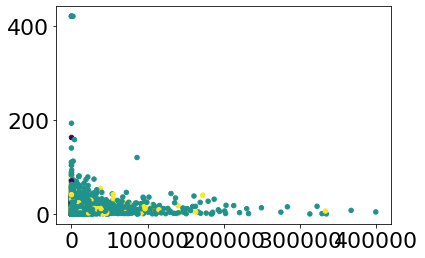

statuses_count - retweet_count_std


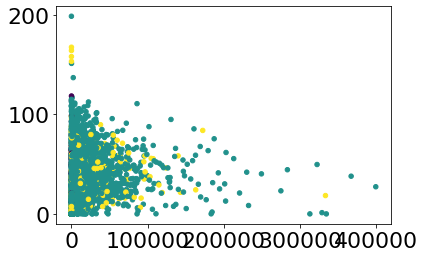

statuses_count - retweet_count_entropy


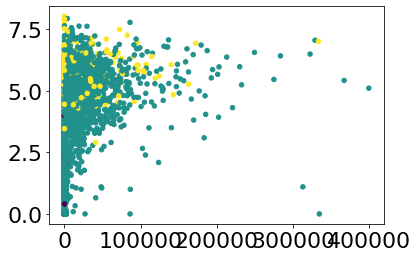

avg_length - avg_special_chars


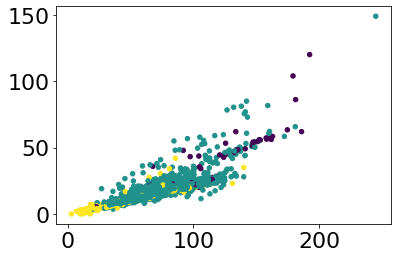

avg_length - urls_ratio


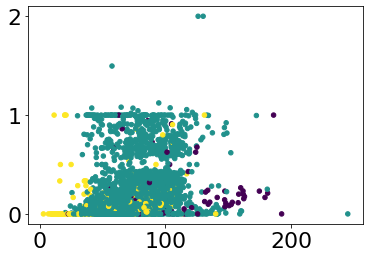

avg_length - mentions_ratio


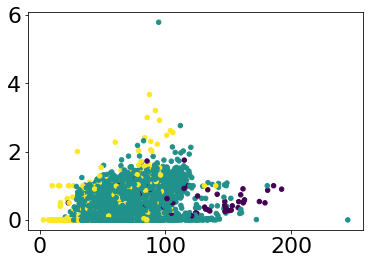

avg_length - hashtags_ratio


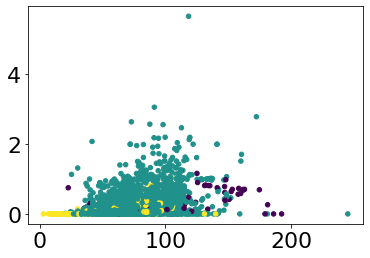

avg_length - reply_count_mean


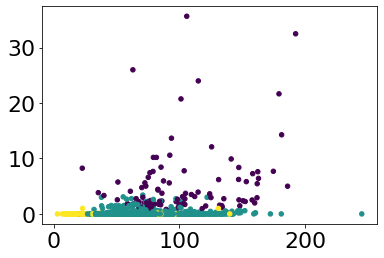

avg_length - reply_count_std


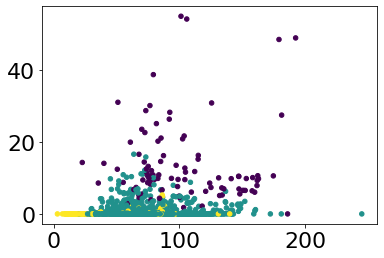

avg_length - reply_count_entropy


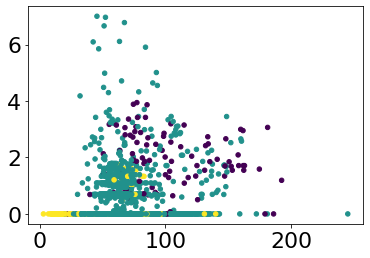

avg_length - favorite_count_mean


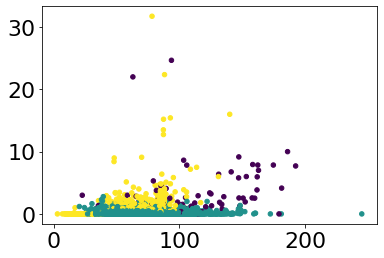

avg_length - favorite_count_std


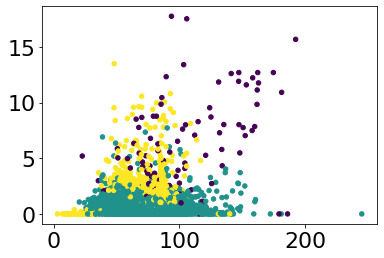

avg_length - favorite_count_entropy


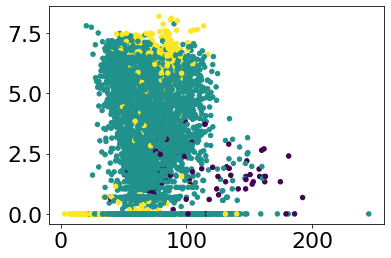

avg_length - retweet_count_mean


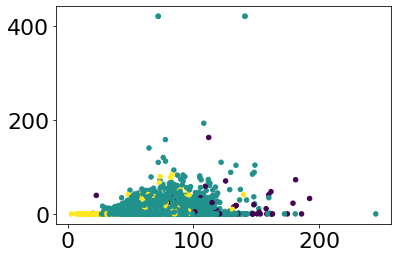

avg_length - retweet_count_std


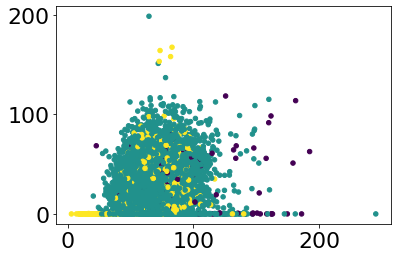

avg_length - retweet_count_entropy


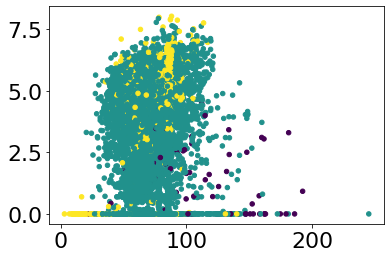

avg_special_chars - urls_ratio


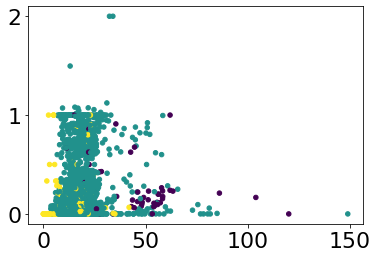

avg_special_chars - mentions_ratio


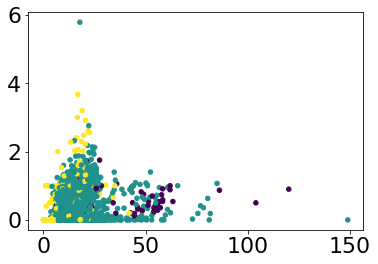

avg_special_chars - hashtags_ratio


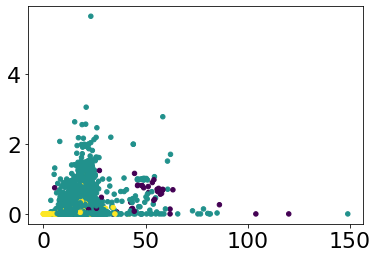

avg_special_chars - reply_count_mean


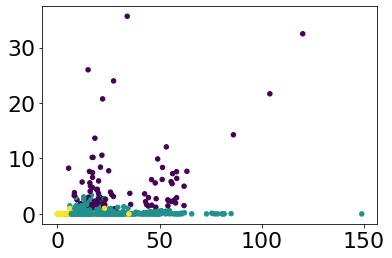

avg_special_chars - reply_count_std


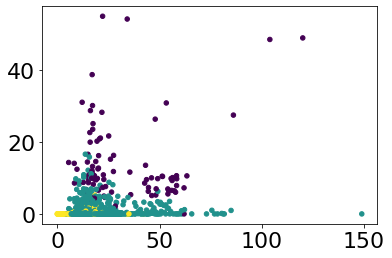

avg_special_chars - reply_count_entropy


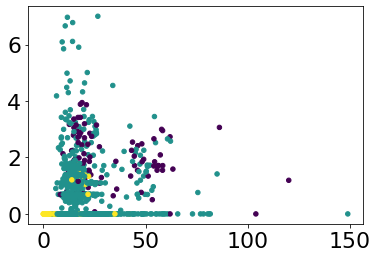

avg_special_chars - favorite_count_mean


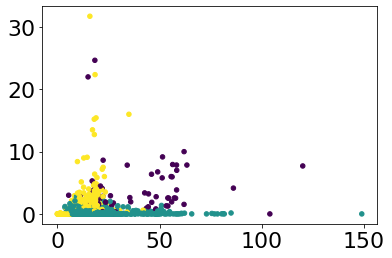

avg_special_chars - favorite_count_std


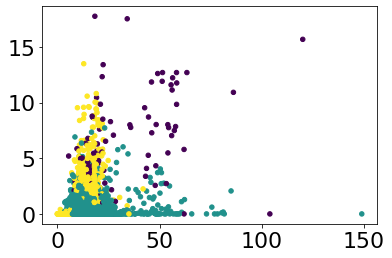

avg_special_chars - favorite_count_entropy


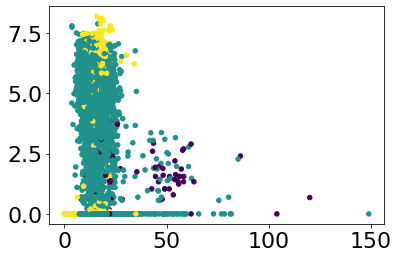

avg_special_chars - retweet_count_mean


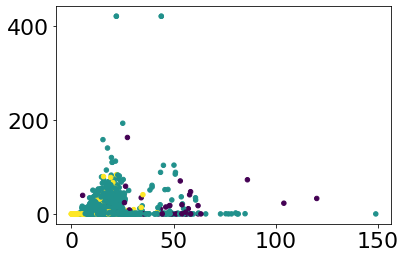

avg_special_chars - retweet_count_std


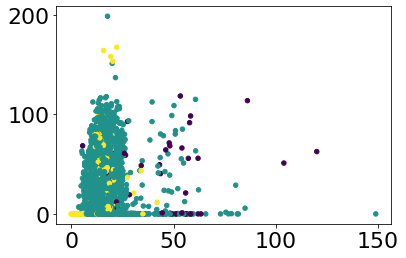

avg_special_chars - retweet_count_entropy


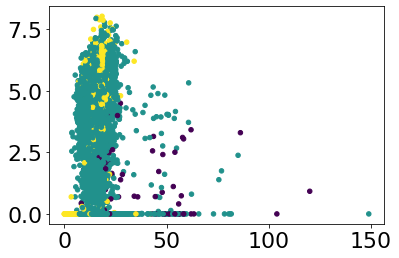

urls_ratio - mentions_ratio


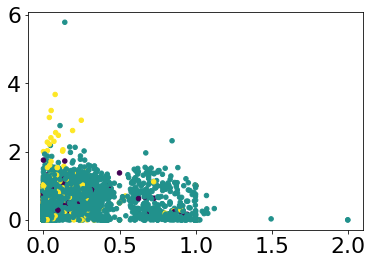

urls_ratio - hashtags_ratio


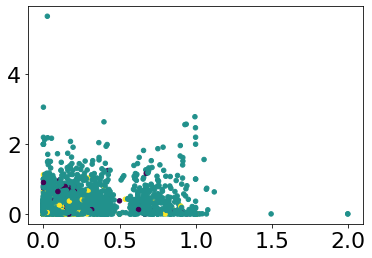

urls_ratio - reply_count_mean


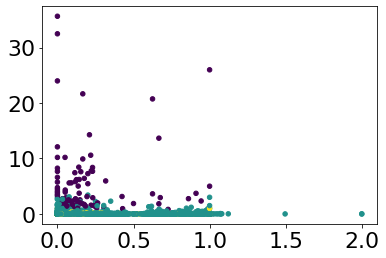

urls_ratio - reply_count_std


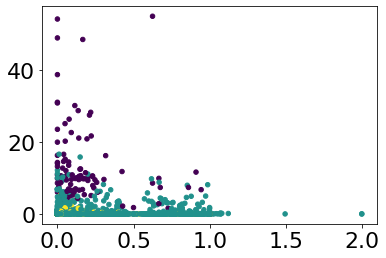

urls_ratio - reply_count_entropy


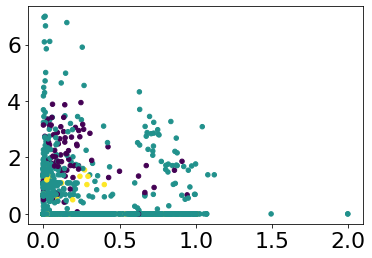

urls_ratio - favorite_count_mean


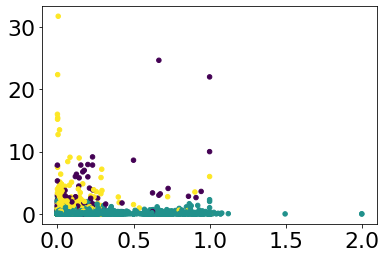

urls_ratio - favorite_count_std


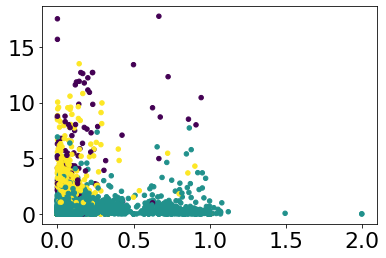

urls_ratio - favorite_count_entropy


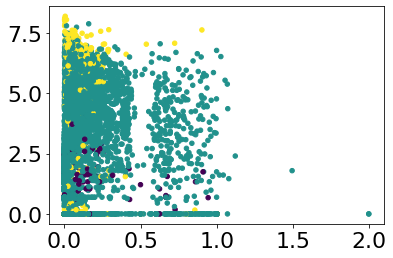

urls_ratio - retweet_count_mean


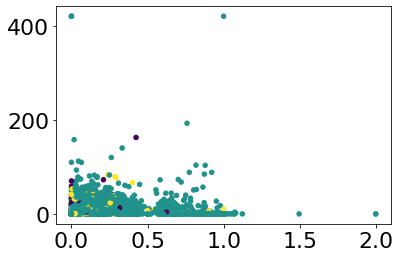

urls_ratio - retweet_count_std


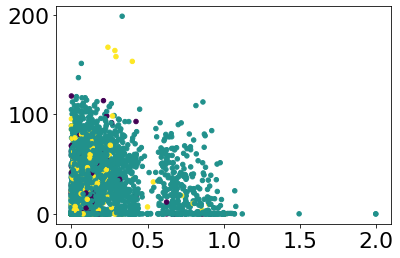

urls_ratio - retweet_count_entropy


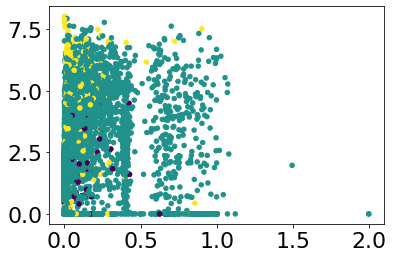

mentions_ratio - hashtags_ratio


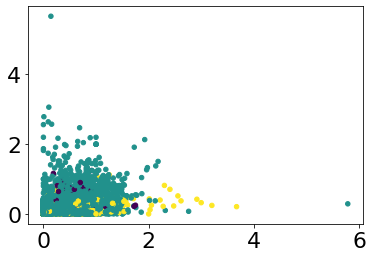

mentions_ratio - reply_count_mean


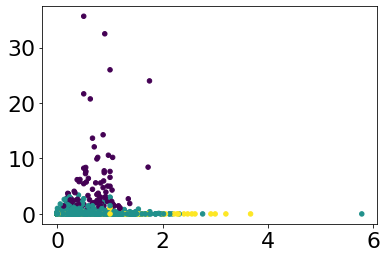

mentions_ratio - reply_count_std


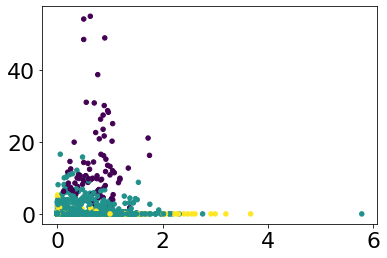

mentions_ratio - reply_count_entropy


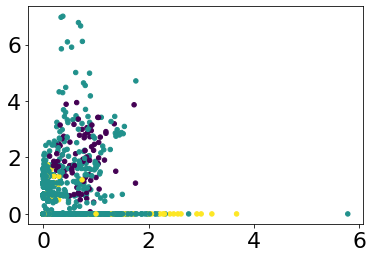

mentions_ratio - favorite_count_mean


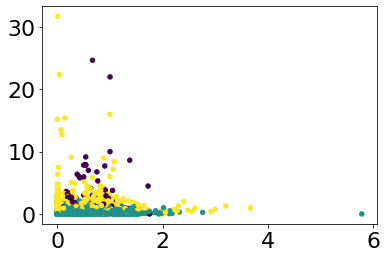

mentions_ratio - favorite_count_std


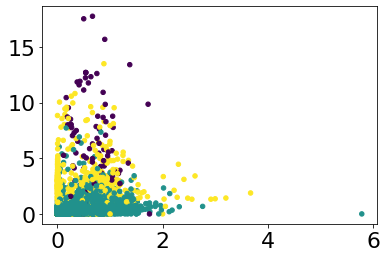

mentions_ratio - favorite_count_entropy


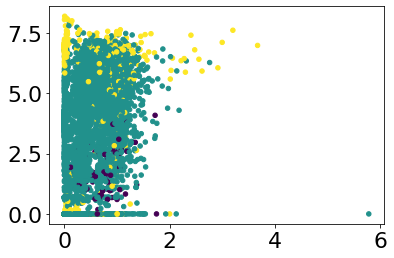

mentions_ratio - retweet_count_mean


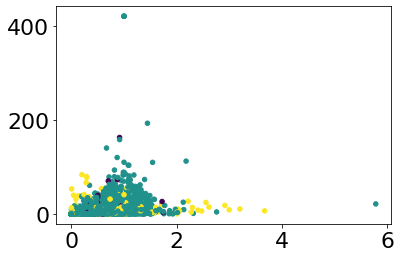

mentions_ratio - retweet_count_std


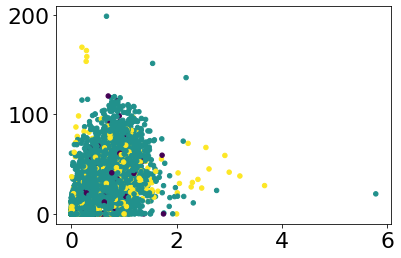

mentions_ratio - retweet_count_entropy


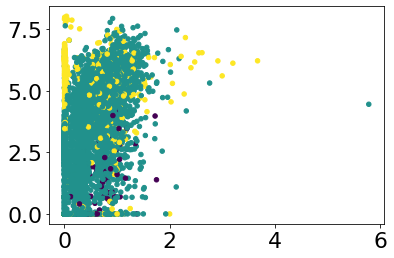

hashtags_ratio - reply_count_mean


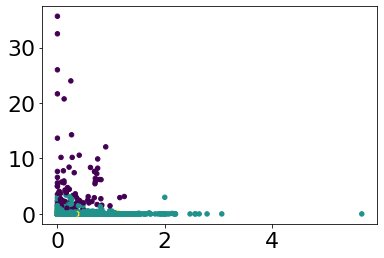

hashtags_ratio - reply_count_std


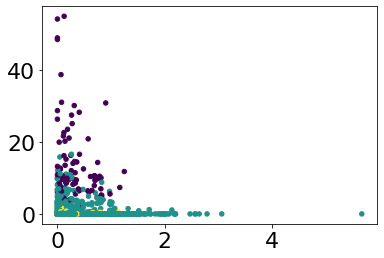

hashtags_ratio - reply_count_entropy


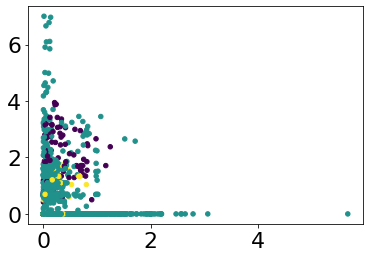

hashtags_ratio - favorite_count_mean


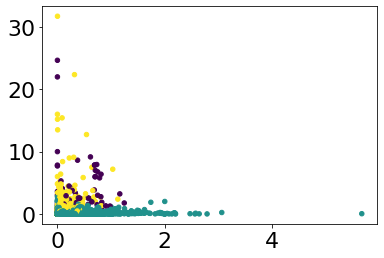

hashtags_ratio - favorite_count_std


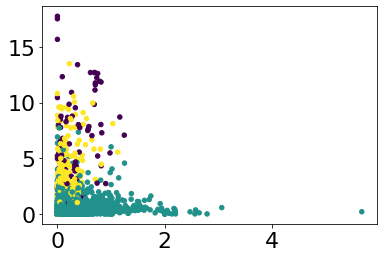

hashtags_ratio - favorite_count_entropy


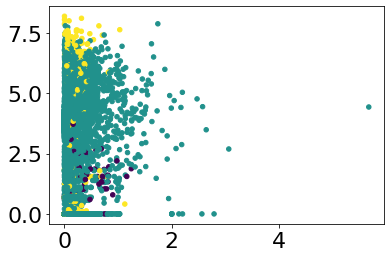

hashtags_ratio - retweet_count_mean


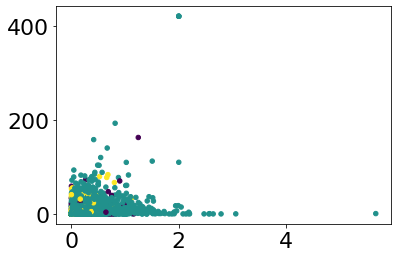

hashtags_ratio - retweet_count_std


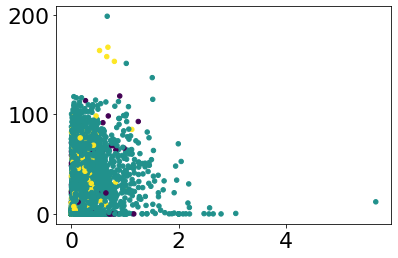

hashtags_ratio - retweet_count_entropy


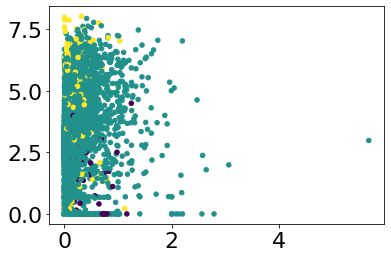

reply_count_mean - reply_count_std


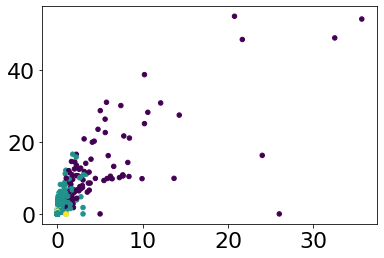

reply_count_mean - reply_count_entropy


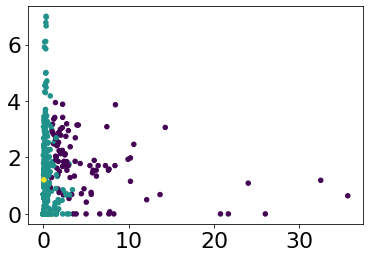

reply_count_mean - favorite_count_mean


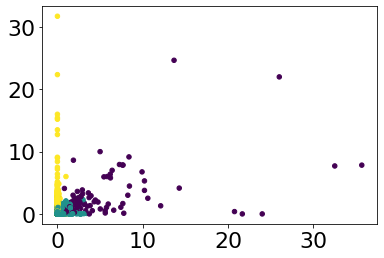

reply_count_mean - favorite_count_std


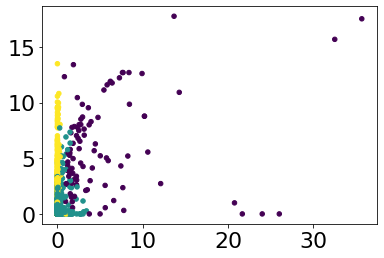

reply_count_mean - favorite_count_entropy


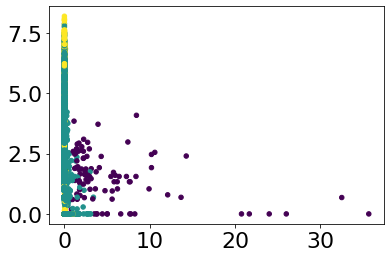

reply_count_mean - retweet_count_mean


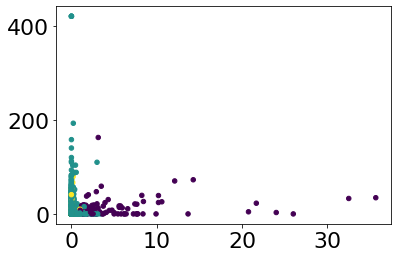

reply_count_mean - retweet_count_std


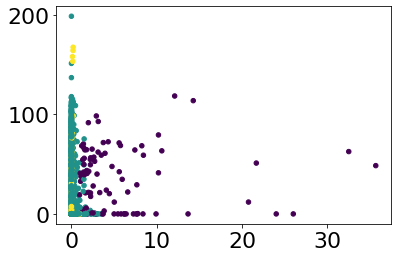

reply_count_mean - retweet_count_entropy


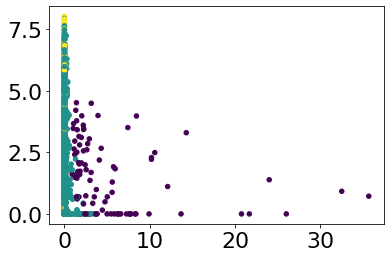

reply_count_std - reply_count_entropy


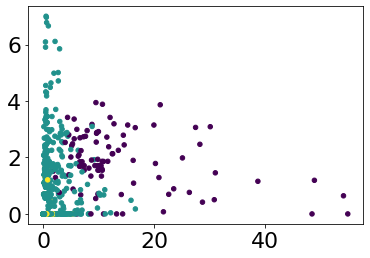

reply_count_std - favorite_count_mean


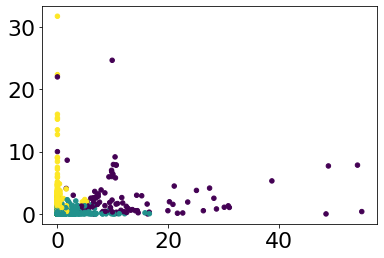

reply_count_std - favorite_count_std


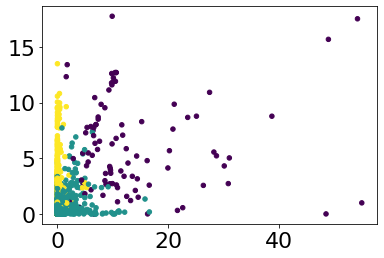

reply_count_std - favorite_count_entropy


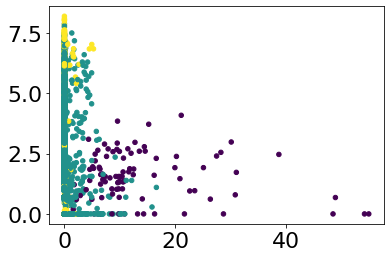

reply_count_std - retweet_count_mean


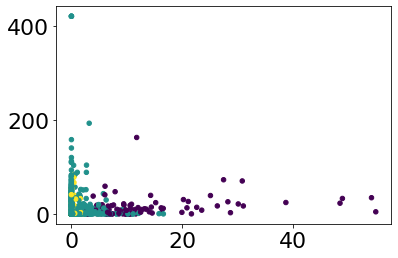

reply_count_std - retweet_count_std


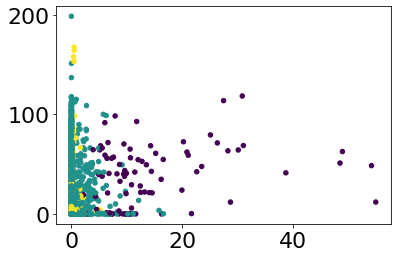

reply_count_std - retweet_count_entropy


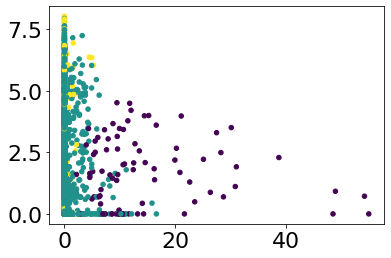

reply_count_entropy - favorite_count_mean


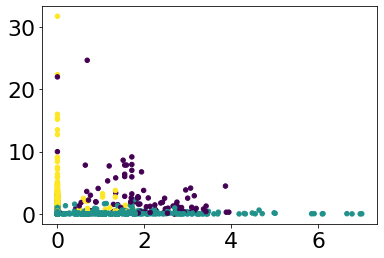

reply_count_entropy - favorite_count_std


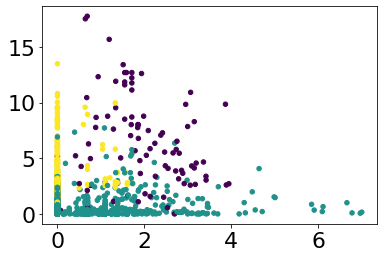

reply_count_entropy - favorite_count_entropy


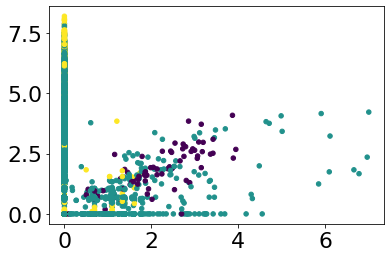

reply_count_entropy - retweet_count_mean


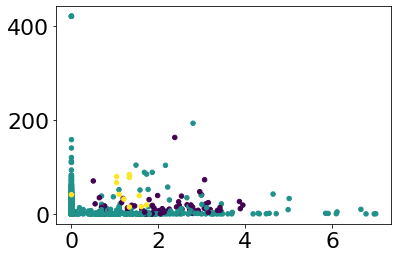

reply_count_entropy - retweet_count_std


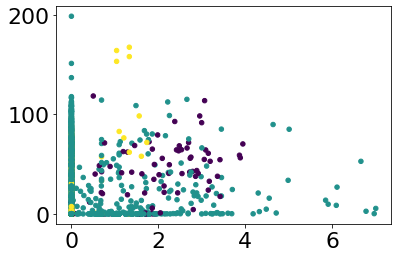

reply_count_entropy - retweet_count_entropy


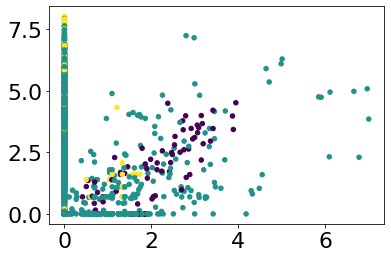

favorite_count_mean - favorite_count_std


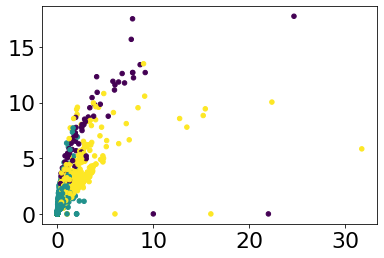

favorite_count_mean - favorite_count_entropy


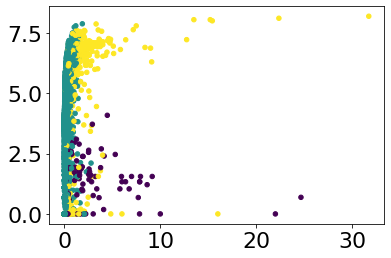

favorite_count_mean - retweet_count_mean


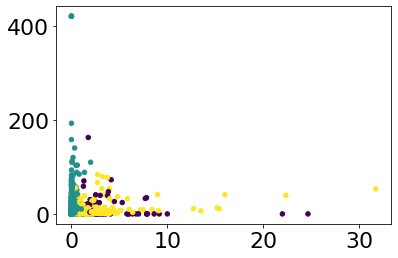

favorite_count_mean - retweet_count_std


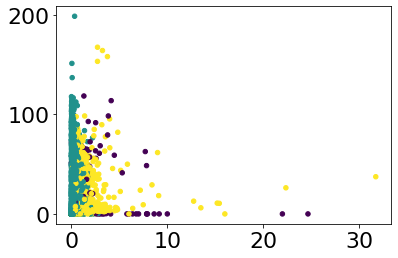

favorite_count_mean - retweet_count_entropy


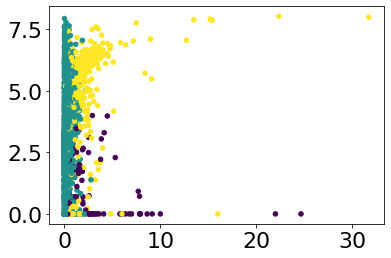

favorite_count_std - favorite_count_entropy


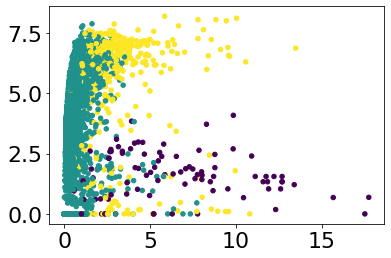

favorite_count_std - retweet_count_mean


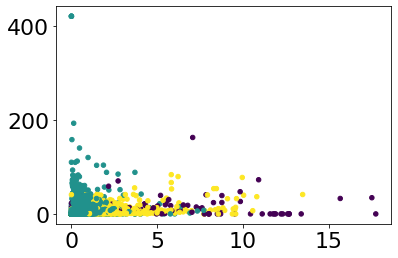

favorite_count_std - retweet_count_std


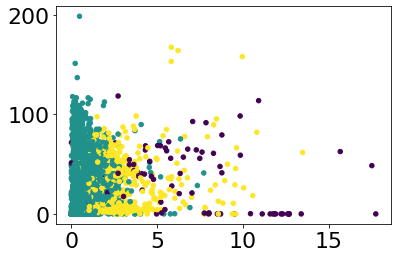

favorite_count_std - retweet_count_entropy


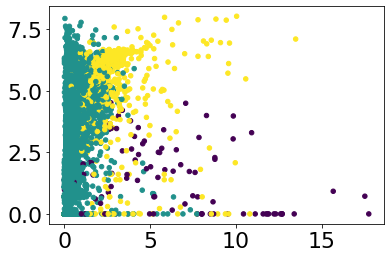

favorite_count_entropy - retweet_count_mean


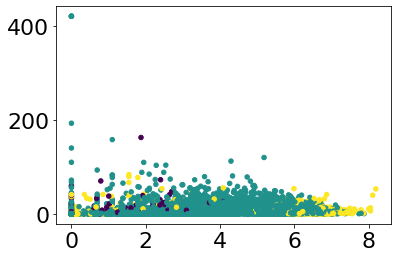

favorite_count_entropy - retweet_count_std


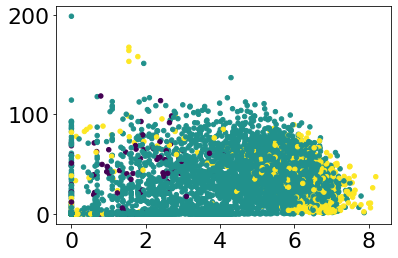

favorite_count_entropy - retweet_count_entropy


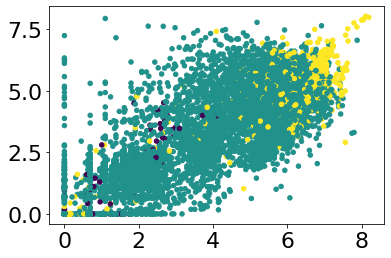

retweet_count_mean - retweet_count_std


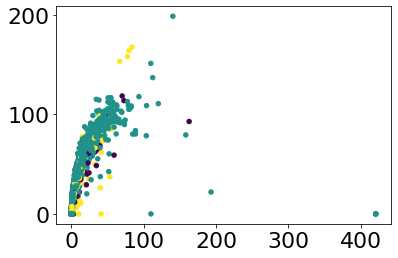

retweet_count_mean - retweet_count_entropy


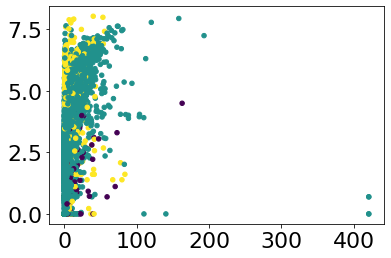

retweet_count_std - retweet_count_entropy


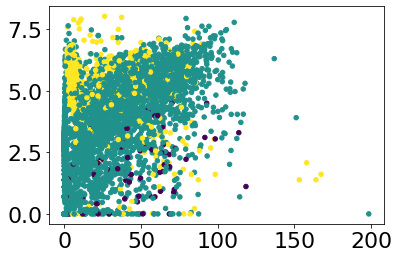

In [81]:
scatter_features_clusters(df_num, res_cluster.labels_)

# dbscan

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
dist = pdist(X, 'euclidean') #vector containing all the distances among points
dist = squareform(dist) #matrix of the distances

In [ ]:
kth_distances = []
for i in range(2,10):
    kth_distances.append(list())
for d in dist:
    index_kth_distance = []
    for i in range(len(kth_distances)):
        index_kth_distance.append(np.argsort(d)[i + 2]) #Return the indice of the k-th neighbor
    i = 0
    for l in kth_distances:
        l.append(d[index_kth_distance[i]]) #Appending the distance of the k-th ordered indice
        i += 1

In [ ]:
counter = 0
for i in (kth_distances):
    plt.plot(range(0, len(i)), sorted(i))
    plt.ylabel('dist from %sth neighbor' % str(counter + 2), fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.ylim([0,0.3])
    plt.show()
    counter += 1

In [ ]:
dbscan = []
counter = 0

for i in best_distance:
    dbscan.append(DBSCAN(eps=i, min_samples=counter + 2).fit(X))
    counter += 1

In [ ]:
best_distance = [0.122, 0.133, 0.139, 0.146, 0.15, 0.15, 0.156, 0.16]

counter_i = 0
for i in dbscan:
    counter_j = 0
    print("DBSCAN with " + str(counter_i + 2) + " neighbors:\n", "Noise Points: " + str(np.unique(i.labels_, return_counts=True)[1][0]) + "\n", "Points in the other clusters:")
    for j in np.unique(i.labels_, return_counts=True)[1]:
        if counter_j != 0:
            print("Cluster " +  str(counter_j) + ": " + str(j) + "   ", end = '')
            if counter_j % 5 == 0:
                print("")
        counter_j += 1
    print("\n")
    counter_i += 1

In [ ]:
plt.scatter(df['urls_ratio'], df['retweet_count_entropy'], c=dbscan[7].labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [ ]:
print('Silhouette %s' % silhouette_score(X, dbscan[4].labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, cluster.labels_))

In [ ]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

In [ ]:
for k in range (1, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.axhline(y=0.07)
    plt.show()

### Plot Cluster Results